Comparing the approximate radius at which an atmospheric outflow velocity becomes sonic to the Roche radius

In [2]:
import numpy as np

from astropy import constants as const
import astropy.units as u
from astropy.units import cds
cds.enable() 

import matplotlib.pyplot as plt

import scipy.optimize as so

%matplotlib inline

In [3]:
#Using Foreman-Mackey's excellent kplr package (http://dan.iel.fm/kplr/) 
#  to interface with the MAST Archive (http://archive.stsci.edu/vo/mast_services.html)
import kplr
client = kplr.API()
confirmed_planets = client.ea_request("exoplanets")
candidate_planets = client.ea_request("cumulative")

In [4]:
#molecular mass of hydrogen gas
#mu = 2.*1.00794*u.g/u.mol
#atomic mass of hydrogen molecule
#amu = 2.*u.u

#molecular mass of hydrogen gas
#mu = 1.00794*u.g/u.mol
#atomic mass of hydrogen molecule
#amu = 1.*u.u

gas_const = const.R

def calc_Teff(a, Rs, Ts):
    return np.sqrt(Rs/a/np.sqrt(2.))*Ts

def calc_vthermal(T, amu=2.*u.u, gamma=7./5):
    #molecular hydrogen's adiabatic index
#    gamma = 7./5
    #atomic hydrogen's adiabatic index
#    gamma = 5./3
    
    return np.sqrt(gamma*const.k_B*T/amu)

def eggletons_rvL1(q, a=1):
    return a*0.49*q**(2./3)/(0.6*q**(2./3) + np.log(1. + q**(1./3)))

def sonic_radius(Mp, vthermal):
    return const.G*Mp/vthermal**2./2.

def Weiss_density(Rp):
    #Returns planetary density as given by Weiss & Marcy (2014) ApJL 783, L6.
    #
    #Rp -- planetary radius (Earths)

    first_dividing_line = 1.5*cds.Rgeo
    second_dividing_line = 4.*cds.Rgeo

    Earths_density = 5.3 #g/cc

    if(Rp < first_dividing_line):
        return (2.43 + 3.39*(Rp.value))
    elif((Rp >= first_dividing_line) and (Rp < second_dividing_line)):
        #Weiss & Marcy give Mp/ME = 2.69 (Rp/RE)**0.93, meaning rhop/rhoE = 2.69 (Mp/ME) (Rp/RE)**(-3) = 2.69*(Rp/RE)**(-2.07).
        
        return (2.69*(Rp.value)**(-2.07))*Earths_density
    else:
        return None

def calc_xcm(q, a=1.):
    return a * 1./(q + 1.)

def calc_omegasq(q, a=1.):
    return (q + 1.)/a**3.

def calc_smallq_roche_lobe(q, a=1.):
    return (q/3.)**(1./3)*a

def calc_smallq_roche_limit(q, Rp=0.1):
    return (q/3.)**(-1./3)*Rp

def calc_approx_rlobe(mass_ratio, a=1.): 
    q = mass_ratio**(1./3)
    
    #Here's what actually appears in Eggleton 1983, apj 268:368-369
    return a*0.49*q*q/(0.6*q*q + np.log(1. + q))

#potential
def potroche(r, q, a=1., theta=0., phi=0.):
    
    omegasq = calc_omegasq(q, a=a)
    xcm = calc_xcm(q, a=1.)
  
    cth  = np.cos(theta)
    sth  = np.sin(theta)
    sphi = np.sin(phi)
    cphi = np.cos(phi)
    
    d2 = np.sqrt( a**2 - 2.*r*a*cth + r**2 )

    #Roche potential
    pot = -q/r - 1./d2 - 0.5 * omegasq * ( (r*sth)**2 + (r*cth - xcm)**2 )
#    pot = -q/r - 1./d2

    #derivative of Roche potential
    pot_r = -q/r**2 + (a*cth - r)/d2**3 + omegasq * ( r*sth**2 + cth*(r*cth - xcm) )

    return pot, pot_r

#d(potential)/dr
def dpotroche_dr(r, q, a=1., theta=0., phi=0.):
    return potroche(r, q, a=a, theta=theta, phi=phi)[1]
    
def find_Lagrange_surface(q, x0 = None):
    if(x0 is None):
#        x0 = calc_smallq_roche_lobe(q)
        x0 = calc_approx_rlobe(q)

    return so.newton(dpotroche_dr, x0, args=(tuple([q])))
#    return so.bisect(dpotroche_dr, 0., 1., args=(q))

#Returns period or semi-major axis, given the other
#  P in days, a in AU, and Mstar in solar masses
def Keplers_Third_Law(P=None, a=None, Mstar=1.*cds.Msun):

    bigG = 4.*np.pi*np.pi/cds.Msun*(cds.au*cds.au*cds.au)/(cds.yr*cds.yr)

    if((P is None) and (a is None)):
        raise ValueError("P or a must be given!")
    elif(a is not None):
        return (a*a*a/(bigG*Mstar/(4.*np.pi*np.pi)))**(1./2)
    elif(P is not None):
        return (P*P*(bigG*Mstar/(4.*np.pi*np.pi)))**(1./3)
    
def calc_xL1(mass_ratio, x0=None, a=1.): 
    if(isinstance(mass_ratio, float)):    
        return find_Lagrange_surface(mass_ratio, x0=x0)
    else:
        ret_val = np.zeros_like(mass_ratio)
        for i in range(len(ret_val)):
            ret_val[i] = find_Lagrange_surface(mass_ratio[i], x0=x0)
        return ret_val

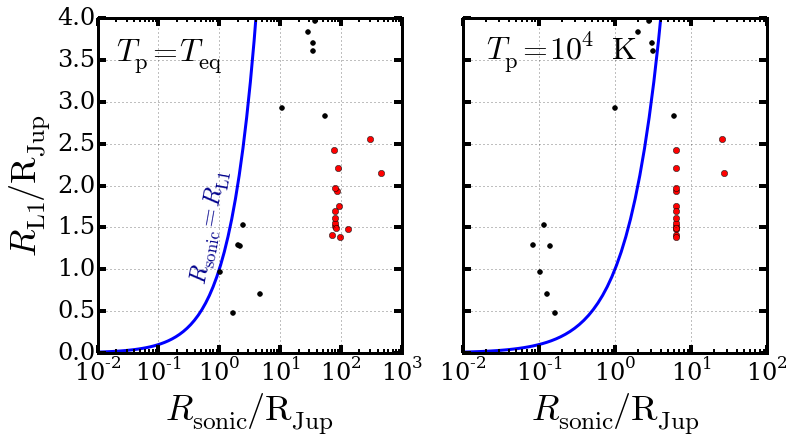

In [32]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharey=ax1)

#Load in mass loss rates
confirmed_hostnames, confirmed_pl_letters, confirmed_P, confirmed_Mdot, confirmed_Rp, confirmed_density =\
    np.load("Jacksonetal_2015_confirmed_planets_Mdot.npy")
confirmed_P = np.array([float(x) for x in confirmed_P])
confirmed_Mdot = np.array([float(x) for x in confirmed_Mdot])
confirmed_Rp = np.array([float(x) for x in confirmed_Rp])

candidate_hostnames, candidate_P, candidate_Mdot, candidate_Rp = \
    np.load("Jacksonetal_2015_candidate_planets_Mdot.npy")

candidate_P = np.array([float(x) for x in candidate_P])
candidate_Mdot = np.array([float(x) for x in candidate_Mdot])
candidate_Rp = np.array([float(x) for x in candidate_Rp])

#According to Rogers (2015 -- http://iopscience.iop.org/0004-637X/801/1/41/), 
#  planets with radii bigger than this are unlikely to be entirely rocky.
Rogers_Rp = 1.6*cds.Rgeo
#Rogers_Rp = 2.*cds.Rgeo
    
#max radius
max_Rp = 2.*cds.Rjup

#max period
max_period = 3. #days

#minimum mass loss rate
min_mass_loss_rate = 1e3 #g/s

cand_or_conf=u'CANDIDATE'

all_Rp = np.array([])
all_sonic_radii_cold = np.array([])
all_sonic_radii_hot = np.array([])
all_rvL1 = np.array([])

for current_planet in confirmed_planets:
    
    Mp = current_planet['pl_bmassj']
    Rp = current_planet['pl_radj']
    Ms = current_planet['st_mass']
    Rs = current_planet['st_rad']
    Ts = current_planet['st_teff']
    a = current_planet['pl_orbsmax']

    if((Mp is not None) and (Rp is not None) and (Ms is not None) and (a is not None)): 
        cur_hostname = current_planet['pl_hostname']
        cur_pl_letter = current_planet['pl_letter']
        
        Mp *= cds.jovMass
        Rp *= cds.Rjup
        Ms *= cds.Msun
        if(Rs is None):
            Rs = 1.
        Rs *= cds.Rsun
        if(Ts is None):
            Ts = 5800.
        Ts *= u.Kelvin
        a *= u.au

        cold_Tp = calc_Teff(a.to('AU'), Rs.to('AU'), Ts)
        hot_Tp = 1e4*u.K
        cold_vthermal = calc_vthermal(cold_Tp)
        hot_vthermal = calc_vthermal(hot_Tp, amu=1.*u.u, gamma=5./3)

        ind = [ind for ind in range(len(confirmed_hostnames)) if 
               (confirmed_hostnames[ind] == cur_hostname) and 
               (confirmed_pl_letters[ind] == cur_pl_letter)]
        if((Rp >= Rogers_Rp) & (Rp <= max_Rp) & (a <= 0.1*u.au) & 
           (3./2*Rp <= eggletons_rvL1((Mp.to('kg')/Ms.to('kg')).value)*a) &
           (confirmed_Mdot[ind] >= min_mass_loss_rate)):
            
            all_Rp = np.append(all_Rp, Rp.to('Rjup'))
            all_sonic_radii_cold = np.append(all_sonic_radii_cold, sonic_radius(Mp, cold_vthermal).to('Rjup'))
            all_sonic_radii_hot = np.append(all_sonic_radii_hot, sonic_radius(Mp, hot_vthermal).to('Rjup'))
            all_rvL1 = np.append(all_rvL1, (eggletons_rvL1(Mp.to('kg')/Ms.to('kg'), a=a)).to('Rjup'))
            
ax1.scatter(all_sonic_radii_cold, all_rvL1, marker='o', color='black', label='Confirmed')
ax2.scatter(all_sonic_radii_hot, all_rvL1, marker='o', color='black')

all_Rp = np.array([])
all_sonic_radii_cold = np.array([])
all_sonic_radii_hot = np.array([])
all_rvL1 = np.array([])

for current_planet in candidate_planets:
    
    if((current_planet['koi_period'] is not None) &\
       (current_planet['koi_period'] < max_period) &\
       (current_planet['koi_prad'] is not None) &\
       (current_planet['koi_srad'] is not None) &\
       (current_planet['koi_slogg'] is not None) &\
       (current_planet['koi_teq'] is not None) &\
       (current_planet['koi_disposition'] == cand_or_conf)):

        cur_hostname = current_planet['kepoi_name']

        Rp = current_planet['koi_prad']*cds.Rjup
        cold_Tp = current_planet['koi_teq']*u.K
        hot_Tp = 1e4*u.K
        cold_vthermal = calc_vthermal(cold_Tp)
        hot_vthermal = calc_vthermal(hot_Tp, amu=1.*u.u, gamma=5./3)

        logg = current_planet['koi_slogg']
        Rs = current_planet['koi_srad']*u.solRad
        period = current_planet['koi_period']*u.day
                
        Ms = ((10.**logg)*u.cm/u.s**2*Rs**2/const.G).to('solMass')
        a = ((const.G*Ms*(period/(2.*np.pi))**2.)**(1./3)).to('AU')

        #If Rp < 4 R_Earth, use Weiss & Marcy (2014) density
        temp_density = Weiss_density(Rp)
        if(temp_density != None):
            Mp = (temp_density*u.g/u.cm**3)*4.*np.pi/3.*Rp**3
        elif(Rp > 4.*cds.Rgeo):
            Mp = 1.*cds.Mjup
    
        ind = [ind for ind in range(len(candidate_hostnames)) if 
               (candidate_hostnames[ind] == current_planet['kepoi_name'])]        
#         if((Rp >= Rogers_Rp) & (Rp <= max_Rp) & (a <= 0.1*u.au) & 
#            (3./2*Rp <= calc_xL1((Mp.to('kg')/Ms.to('kg')).value)*a):

        if((Rp >= Rogers_Rp) & (Rp <= max_Rp) & (a <= 0.1*u.au) & 
           (3./2*Rp <= calc_xL1((Mp.to('kg')/Ms.to('kg')).value)*a) &
           (candidate_Mdot[ind] > min_mass_loss_rate)):
            
            all_Rp = np.append(all_Rp, Rp.to('Rjup'))
            all_sonic_radii_cold = np.append(all_sonic_radii_cold, sonic_radius(Mp, cold_vthermal).to('Rjup'))
            all_sonic_radii_hot = np.append(all_sonic_radii_hot, sonic_radius(Mp, hot_vthermal).to('Rjup'))
            all_rvL1 = np.append(all_rvL1, (eggletons_rvL1(Mp.to('kg')/Ms.to('kg'), a=a)).to('Rjup'))

ax1.semilogx(all_sonic_radii_cold, all_rvL1, marker='o', color='red', label='Candidate KOI', ls='None')
ax2.semilogx(all_sonic_radii_hot, all_rvL1, marker='o', color='red', ls='None')

#ax1.set_xlabel('$R_{\\rm p} ({\\rm R_{Jup}})$', fontsize=36)
ax1.set_xlabel('$R_{\\rm sonic}/{\\rm R_{Jup}}$', fontsize=36)
ax1.set_ylabel('$R_{\\rm L1}/{\\rm R_{Jup}}$', fontsize=36)
ax1.semilogx(10.**(np.linspace(-2, 1)), 10.**(np.linspace(-2, 1)), zorder=-1)
#ax1.set_xlim([0., 200.])
ax1.set_ylim([0., 4.])
ax1.tick_params(which='major', axis='both', labelsize=24)
ax1.text(2e-2, 3.5, "$T_{\\rm p} = T_{\\rm eq}$", fontsize=32)
#ax1.legend(loc='best', scatterpoints=1, fontsize=20)
# ax1.annotate('$R_{\\rm sonic} = R_{\\rm L1}$', xy=(2,2), xytext=(0.02, 2.5), fontsize=24, color='blue', 
#            arrowprops=dict(facecolor='blue', shrink=0.1))
ax1.text(0.3, 2, '$R_{\\rm sonic} = R_{\\rm L1}$', rotation=80, fontsize=24, color='darkblue')

ax2.set_xlabel('$R_{\\rm sonic}/{\\rm R_{Jup}}$', fontsize=36)
ax2.semilogx(10.**(np.linspace(-2, 1)), 10.**(np.linspace(-2, 1)), zorder=-1)
#ax2.set_xlim([0., 10.])
ax2.tick_params(which='major', axis='x', labelsize=24)
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.text(2e-2, 3.5, "$T_{\\rm p} = {\\rm 10^4\ K}$", fontsize=32)

fig.savefig('comparing_sonic_and_Roche_radii.eps', dpi=500, bbox_inches='tight')